In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import jabble.dataset
import jabble.loss
import jabble.model

import matplotlib.pyplot as plt
from matplotlib import cm

from jax import jit
import jax.numpy as jnp
from functools import partial

<h1>52 - Splines of higher B order on simple absorption lines</h1>
redo the simulated data in the simplest way possible. just star no tellurics maybe gaussian noise

In [2]:
def alpha_recursion(i,j,p):
    # fixed values
    if i < 0 or i > p:
        return 0
    if j < 0 or j > p:
        return 0
    if p == 0:
        return 1
    # recursion
    return  (j/p) * alpha_recursion(i,j,p-1) +\
            (1/p) * alpha_recursion(i-1,j,p-1) +\
            ((p+1-j)/p) * alpha_recursion(i,j-1,p-1) -\
            (1/p) * alpha_recursion(i-1,j-1,p-1)

In [3]:
class BSpline:
    def __init__(self,p):
        # calculate coefficients of basis spline functions(piecewise polynomial)
        # p piecewise functions with p+1 terms
#         p = p.astype(int)
        p = int(p)
        self.p = p
        self.alphas = np.zeros((p+1,p+1))
        for i in range(p+1):
            for j in range(p+1):
                self.alphas[i,j] = alpha_recursion(i,j,p)
        self.alphas = jnp.array(self.alphas)
        
    @partial(jit,static_argnums=[0])
    def __call__(self,x,*args):
        # Recentering 
        i = jnp.floor(x + (self.p+1) / 2).astype(int)
        cond1 = i >= 0
        cond2 = i <= self.p
        f = jnp.where((cond1 * cond2), \
                      jnp.polyval(self.alphas[::-1,i], (x + (self.p+1) / 2) % 1), \
                      0.0)
        return f

In [4]:
def _sparse_design_matrix(x,xp,dx,basis,a):
    '''Internal Function for general_interp_simple
    to do: 
    make sparse using 'a' and fast
    choose fast sparse encoding
    the fastest for lstsq solve
    time all'''
    
    
    return basis((x[None,:] - xp[:,None])/dx)

In [5]:
@partial(jit,static_argnames=['basis','a'])
def general_interp_loose(x, xp, ap, basis, a):
    '''XP must be equally spaced
    deal boundary conditions 0D, 0N
    padding points
    with user inputs values
    
    for future test for a, where basis function goes to zero'''
    dx = xp[1] - xp[0]# GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
#     X    = _sparse_design_matrix(xp,xp,dx,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
#     alphas,res,rank,s = jnp.linalg.lstsq(X,fp)
    
    return (ap[:,None] * _sparse_design_matrix(x,xp,dx,basis,a)).sum(axis=0)

In [6]:
class BSplineModel(jabble.model.Model):
    def __init__(self,xs,p_val=2,p=None):
        super(BSplineModel,self).__init__()
        # when defining ones own model, need to include inputs as xs, outputs as ys
        # and __call__ function that gets ya ther, and params (1d ndarray MUST BE BY SCIPY) to be fit
        # also assumes epoches of data that is shifted between
        self.spline = BSpline(p_val)
        self.p_val = p_val
        self.xs = xs
        if p is not None:
            if p.shape == self.xs.shape:
                self.p = p
            else:
                logging.error('p {} must be the same shape as x_grid {}'.format(p.shape,xs.shape))
        else:
            self.p = np.zeros(xs.shape)

    def call(self,p,x,i):
        # print()
        # print(p.shape)
        y = general_interp_loose(x, self.xs, p, basis=self.spline, a=self.p_val//2)
        return y

In [7]:
import os
import datetime
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%d-%m-%y"))
os.makedirs(out_dir,exist_ok=True)

In [8]:
def gaussian(x,mu,sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) #/ (2 * sigma * np.sqrt(2 * np.pi))

In [9]:
resolution = 120_000
snr        = 150
epoches    = 20

dx = jabble.dataset.delta_x(resolution)
dl = 4540/resolution
print(dx,dl)
wave_grid = np.arange(4400,4410,dl) * u.Angstrom
x_grid    = np.log(wave_grid.to(u.Angstrom).value)

time = np.linspace(0,60,epoches) * u.day
period = 120 * u.day
planet_period = 2.45 * u.day

guess_vel = 60 * u.km/u.s  * np.cos(2*np.pi * time / period * u.rad)
extra_vel = 2 * u.km/u.s * np.cos(2*np.pi * time / planet_period * u.rad)
# guess_vel  = np.linspace(-60,60,epoches) * u.km/u.s
# extra_vel  = np.linspace(-10,10,epoches) * u.m/u.s
velocities = guess_vel + extra_vel
shifts     = jabble.dataset.shifts(velocities).value

# print(shifts)

mean = np.log(4550)

start_peaks = 1
end_peaks = 6
step_size = 1
peaks_vector = np.repeat(np.arange(start_peaks,end_peaks,step_size,dtype=int),repeats=1).flatten()
n_peaks = len(peaks_vector)
fluxes = np.ones((n_peaks,epoches,*wave_grid.shape))

x_padding = 3*(np.log(4551) - np.log(4550))

lines_array = np.zeros((len(peaks_vector),np.max(peaks_vector)))
for i,value in enumerate(peaks_vector):
    print(value)
    
    placements = np.random.uniform(np.min(x_grid) + np.max(shifts) + x_padding,\
                                   np.max(x_grid) - np.max(shifts) - x_padding,value)
#     placements = np.linspace(np.min(x_grid) + np.max(shifts) + x_padding,np.max(x_grid) - np.max(shifts) - x_padding,value)
    lines_array[i,:value] = placements
    for placement in placements:
        fluxes[i,:,:] -= 0.7 * gaussian(np.repeat((x_grid)[np.newaxis,:],epoches,axis=0),\
                                        np.repeat((placement + shifts)[:,np.newaxis],wave_grid.shape[0],axis=1),dx)
    
    noise = np.zeros(fluxes.shape[0:2])
    for j in range(fluxes.shape[1]):
        for k in range(fluxes.shape[2]):
            fluxes[i,j,k] -= np.random.normal(0.0,np.abs(fluxes[i,j,k]/snr))
ferr = fluxes/snr

8.333298611358605e-06 0.03783333333333333
1
2
3
4
5


In [10]:
import scipy.ndimage

In [11]:
datasets = []
for i in range(fluxes.shape[0]):
    datasets.append(jabble.dataset.Dataset.from_flux(np.repeat((wave_grid)[np.newaxis,:],epoches,axis=0),fluxes[i,:,:],ferr[i,:,:],mask=np.ones(fluxes[0,...].shape),normalize=scipy.ndimage.gaussian_filter,nargs=[1000]))

In [12]:
print(len(datasets))

5


In [13]:
# plt_inds = epoches
# plt_ds = len(datasets)
# xpmin = np.log(4550)
# xpmax = np.log(4560)
# fig, axes = plt.subplots(plt_ds,plt_inds,figsize=(5*plt_inds,plt_ds),sharey=True)
# for ele in range(plt_inds):
# #     ele = ele*3
#     for ds_i in range(plt_ds):
#         axes[ds_i,ele].errorbar(datasets[ds_i].xs[ele,:],datasets[ds_i].ys[ele,:],datasets[ds_i].yerr[ele,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
# #     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
#         axes[ds_i,ele].set_ylim(-2,0.2)
# #         axes
# plt.show() 

In [14]:
loss = jabble.loss.ChiSquare()
init_vels   = guess_vel
init_shifts = jabble.dataset.shifts(init_vels)

In [15]:
vel_padding = 100 * u.km/u.s
model_grid = jabble.model.create_x_grid(x_grid,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
model_list = []
bspline_order = 4
for i in range(n_peaks):
    for j in range(1, bspline_order):
#         print(j)
        model_list.append(jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),BSplineModel(model_grid,j)]))

2023-04-11 13:37:15.705112: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2023-04-11 13:37:15.705133: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
len(model_list)

15

In [17]:
def train_cycle(model,dataset,loss,fit1_inds,fit2_inds):
    options = {"maxiter":15000,'maxls':128,'ftol':1e-40,'gtol':1e-35,'tol':1e-30,'eps':1e-22}
    
    # Fitting Round 1
    print('fitting round 1')
    model.fix()
    model.fit(1)
    res1 = model.optimize(loss,dataset,options=options,verbose=False)
    print(res1['message'],res1['nit'])
    
    # Fitting Round 2
    print('fitting round 2')
    model.fix()
    model.fit(0)
    res2 = model.optimize(loss,dataset,options=options,verbose=False)
    print(res2['message'],res2['nit'])
    
    # Fitting Round 3
    print('fitting round 3')
    model.fix()
    model.fit(1)
    res3 = model.optimize(loss,dataset,options=options,verbose=False)
    print(res3['message'],res3['nit'])
    
    # Fitting Round 4
    print('fitting round 4')
    model.fix()
    model.fit(0)
    model.fit(1)
    res4 = model.optimize(loss,dataset,options=options,verbose=False)
    print(res4['message'],res4['nit'])

#     # Fitting Round 5
#     print('fitting round 5')
#     model.fix()
#     model.fit(0)
#     model.fit(1)
#     res5 = model.optimize(loss,dataset,options=options,verbose=True)
#     print(res5['message'],res5['nit'])
    return model

In [18]:
ind1 = [[1]]
ind2 = [[0],[1]]

for i in range(n_peaks):
    for j in range(1, bspline_order):
# for i,model in enumerate(model_list):
#     print('model #{}'.format(i))
        model_list[i * (bspline_order-1) + j - 1] = train_cycle(model_list[i * (bspline_order-1) + j - 1],datasets[i],loss,ind1,ind2)

fitting round 1


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 14
fitting round 2
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 5
fitting round 3
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 17
fitting round 4
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 3
fitting round 1
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 16
fitting round 2
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 8
fitting round 3
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 24
fitting round 4
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 3
fitting round 1
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 20
fitting round 2
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 5
fitting round 3
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 36
fitting round 4
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 2
fitting round 1
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 15
fitting round 2
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 7
fitting round 3
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 18
fitting round 4
CO

In [19]:
import matplotlib.pyplot as plt

In [20]:
velocities.to(u.m/u.s)

<Quantity [ 62000.        ,  58697.25235594,  54983.70290447,
            54108.02317717,  48464.82621316,  38756.48528336,
            32611.41256968,  26081.6728235 ,  13975.4684744 ,
             3339.90613408,  -3418.8226677 , -13858.32273203,
           -26059.50471548, -32739.29711657, -38716.70281127,
           -48356.21332406, -54200.42054019, -55047.55612262,
           -58573.92284355, -61995.8907855 ] m / s>

In [21]:
# plt_ds = n_peaks
# fig,axes = plt.subplots(plt_ds,figsize=(5,10),sharex=True,sharey=True)

# for i in range(plt_ds):
#     axes[i].plot(extra_vel.to(u.m/u.s).value,'.g')
#     axes[i].plot(jabble.dataset.velocities(model_list[i][0].p).to(u.m/u.s).value + init_vels.to(u.m/u.s).value,'.r')
#     axes[i].set_ylabel('# {}'.format(i))
#     # axes.supylabel('dv [m/s]')
# plt.xlabel('epoches')
# plt.show()

In [22]:
def norm_func(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low/y

In [23]:
n_peaks

5

In [24]:
# for i,model in enumerate(model_list):
#     print('model #{}'.format(i))
# #     print(model.results)
#     for result in model.results:
#         print(result['message'])
#         print(result['nit'])

IndexError: list index out of range

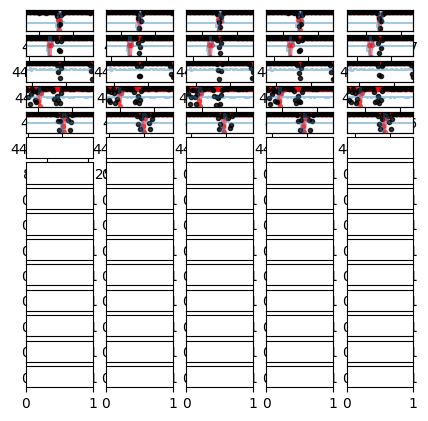

In [41]:
lmin = 4397
lmax = 4415
x_window = np.log(4551) - np.log(4550.0)

lrange = np.arange(lmin,lmax,1)
plt_unit = u.Angstrom
plt_epoch = epoches//4
plt_ds = len(datasets)*3
fig, axes = plt.subplots(plt_ds,plt_epoch,figsize=(5,5),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=100)
for i in range(plt_ds):
    for j in range(plt_epoch):
        axes[i,j].set_xlim(np.log(lmin),np.log(lmax))
    #         datasets[i].plot_star(axes[i,j],j,xy='xy',units=plt_unit,normalize=normalize_2,nargs=[sigma])
    #     data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit)
        axes[i,j].errorbar(datasets[i].xs[j,:],datasets[i].ys[j,:],datasets[i].yerr[j,:],fmt='.k',elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
        axes[i,j].plot(model_list[i][1].xs+model_list[i][0].p[j],model_list[i][1].p,'.r',linestyle='solid',linewidth=2.2,zorder=1,alpha=0.5,ms=6)
        
        
        
        axes[i,j].set_ylim(-1.4,0.2)
        
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks(np.log(lrange))
        axes[i,j].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        axes[i,j].set_xlim(lines_array[i,0]-x_window+model_list[i][0].p[j],\
                           lines_array[i,0]+x_window+model_list[i][0].p[j])
        res_ax = axes[i,j].twinx()
        res_ax.set_yticks([])
        residual = loss(model_list[i].get_parameters(),datasets[i],j,model_list[i])
#         res_ax.step(datasets[i].xs[j,:],residual,where='mid',alpha=0.3,label='residual')
        res_ax.step(model_list[i][1].xs+model_list[i][0].p[j],\
                model_list[i].results[-1]['jac'][model_list[i][0].p.shape[0]:],\
                where='mid',alpha=0.4,label='gradient',zorder=-1)
#         res_ax.set_xlim(xpmin,xpmax)
#         res_ax.set_ylim(-1e2,1e2)
    #     axes[j].plot(np.log(data['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(norm_func(data['theory']['interpolated']['star']['flux'][j,:],sigma)))
    
plt.savefig(os.path.join(out_dir,'52-allplots.png'),dpi=300,bbox_inches='tight')
plt.show()

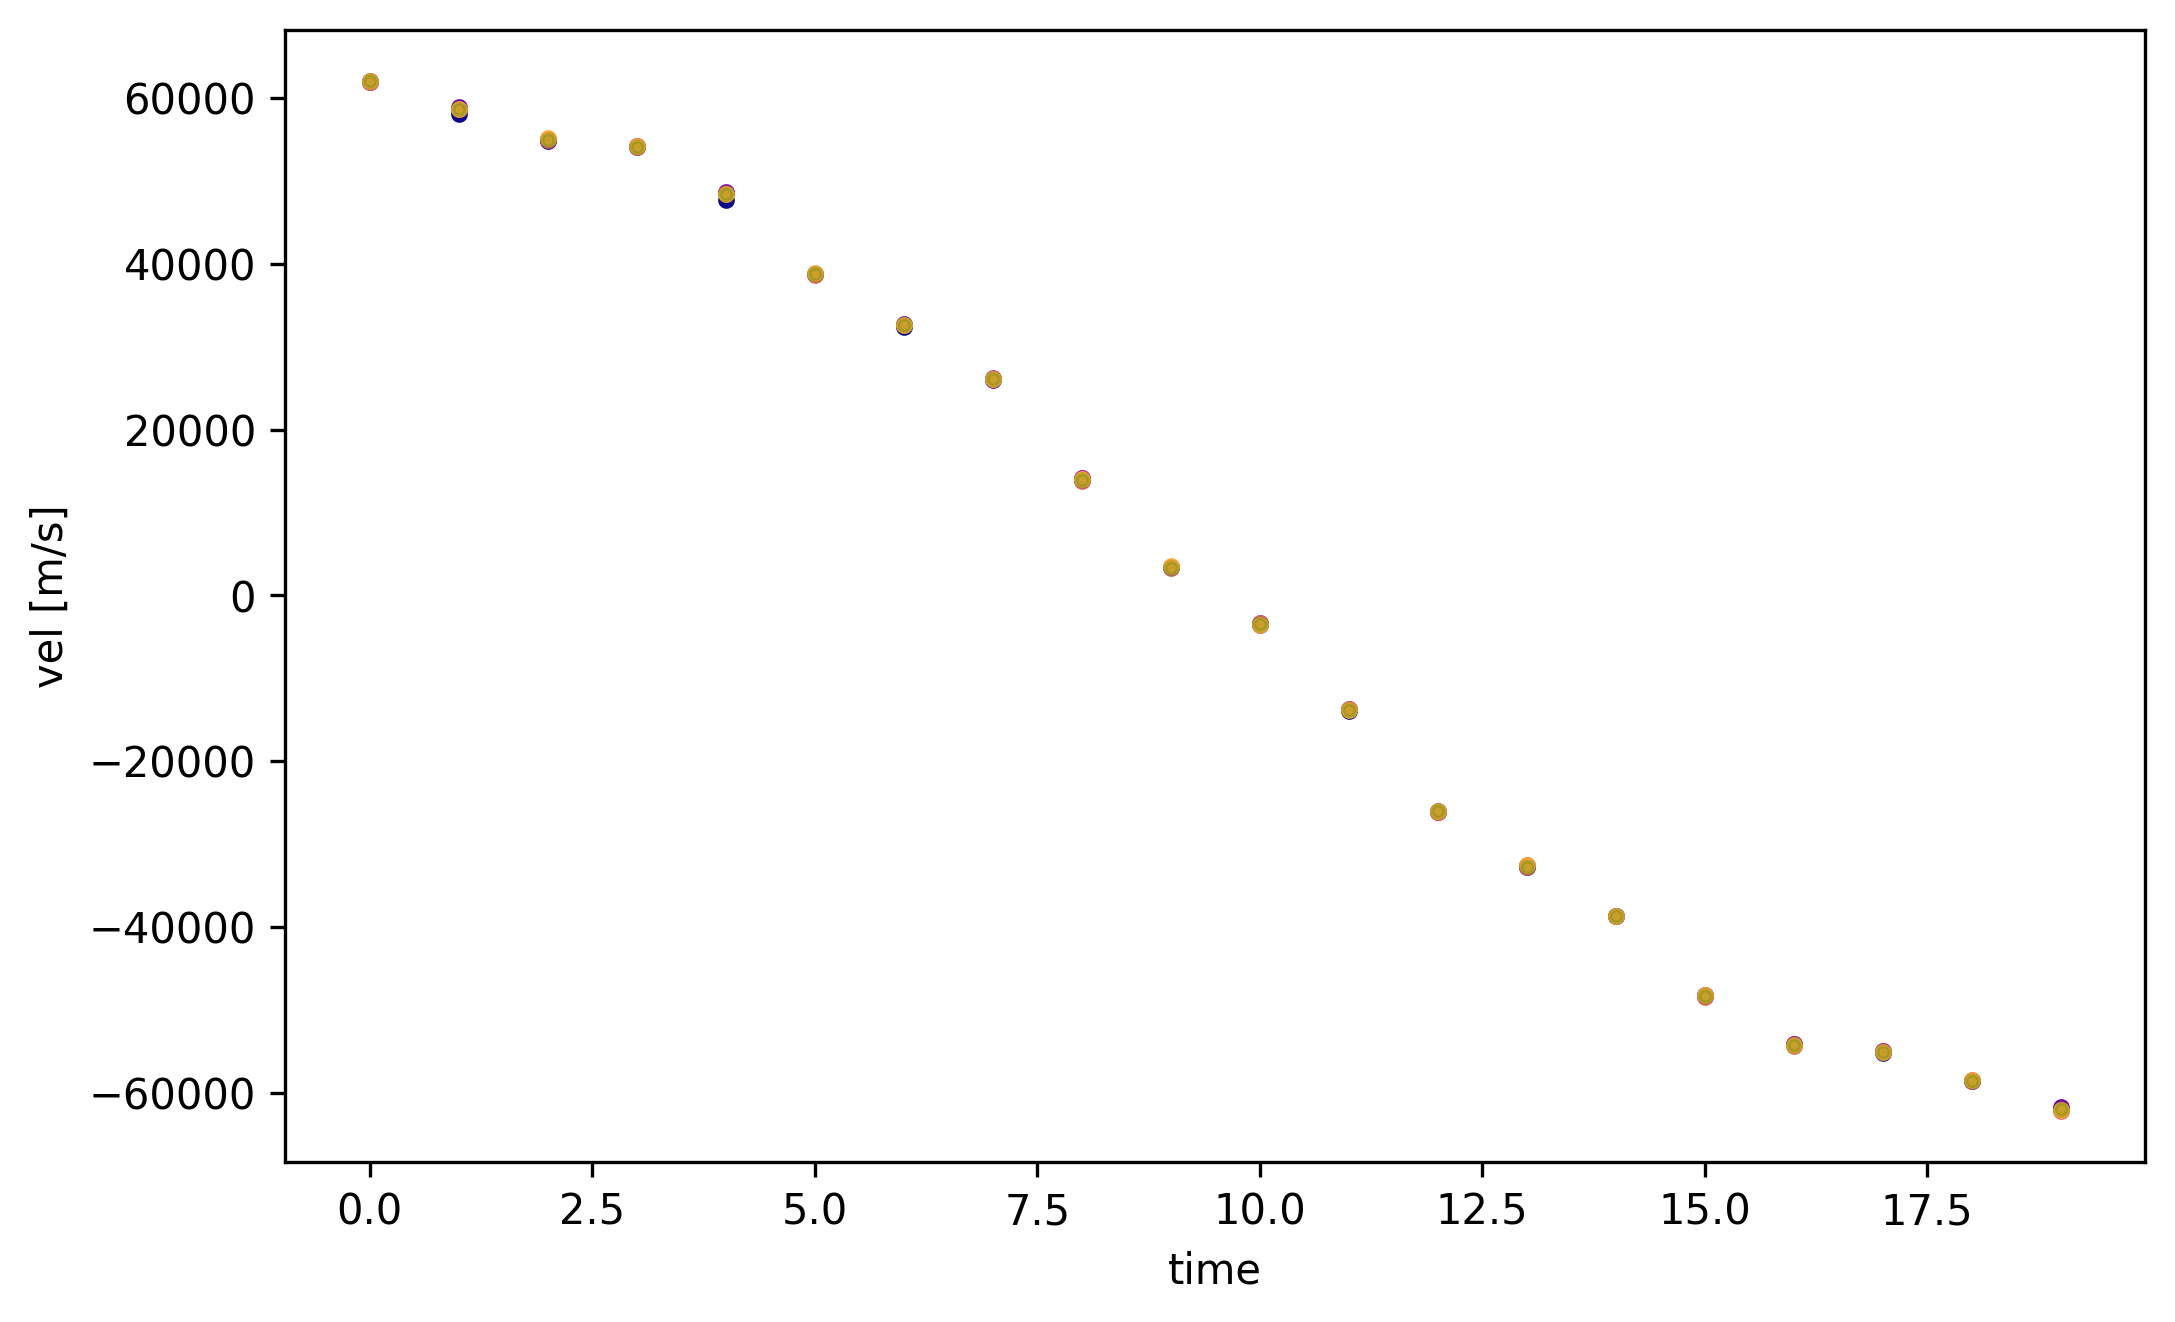

In [26]:
plt_ds = n_peaks
fig,ax = plt.subplots(1,figsize=(8,5),sharex=True,sharey=True,facecolor=(1,1,1),dpi=300)
estimate_vel = np.zeros((len(model_list),epoches))
for i in range(plt_ds):
    estimate_vel[i,:] = jabble.dataset.velocities(model_list[i][0].p).to(u.m/u.s).value

for i in range(plt_ds):
    
    ax.plot(estimate_vel[i,:],'.',color=cm.plasma(i/n_peaks))
#     ax.set_ylabel('# {}'.format(i))
ax.plot((velocities.to(u.m/u.s).value),'.g',alpha=0.2)
plt.ylabel('vel [m/s]')
plt.xlabel('time')
plt.savefig(os.path.join(out_dir,'43-vel.png'))
plt.show()

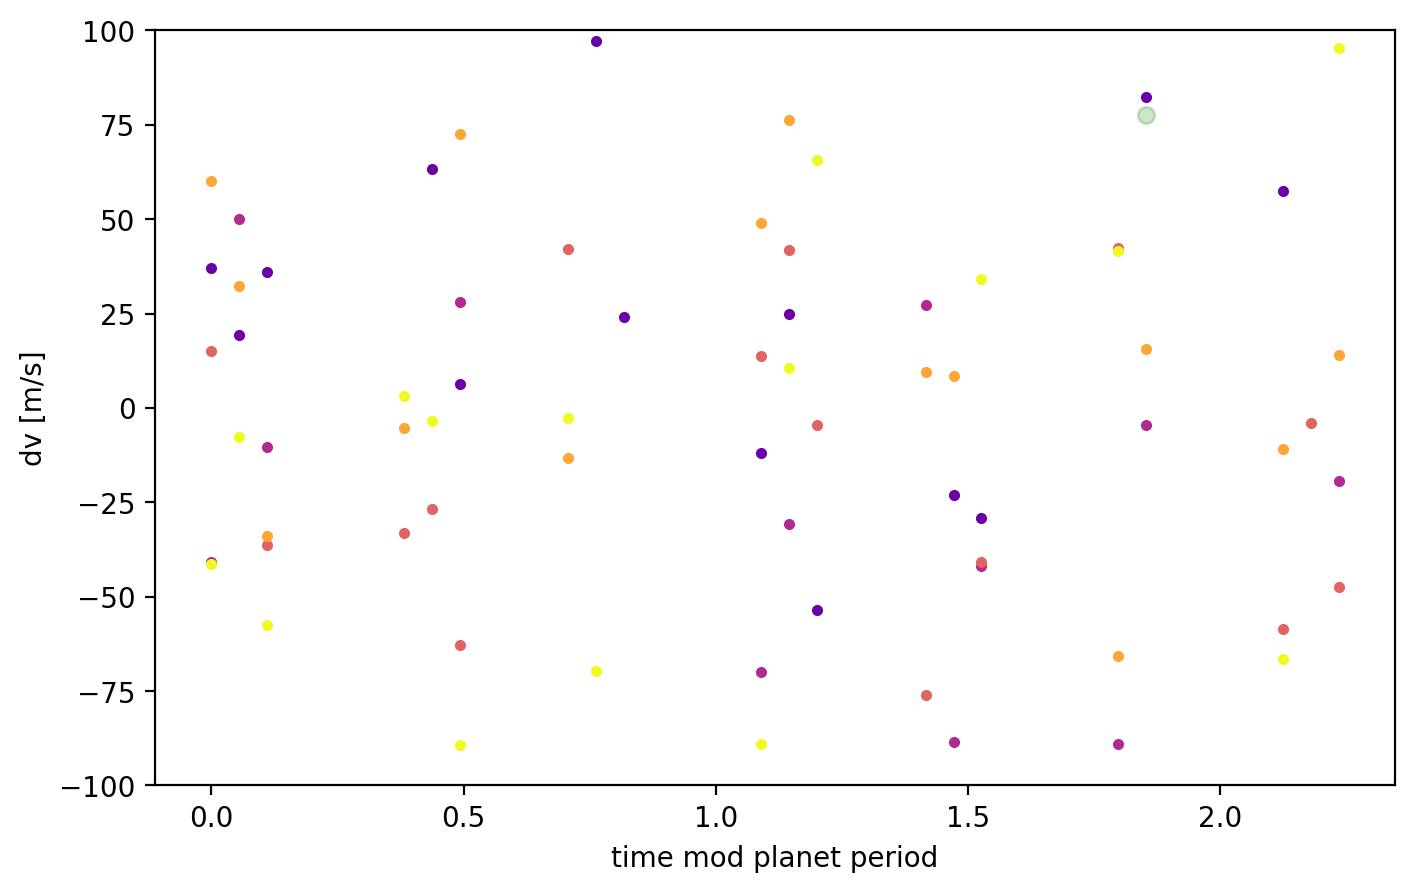

In [27]:
# plt_ds = n_peaks
fig,ax = plt.subplots(1,figsize=(8,5),sharex=True,sharey=True,facecolor=(1,1,1),dpi=200)

for i,num_peaks in enumerate(peaks_vector):
#     ax.plot(,'.g')
    symb = '.'
    if model_list[i].results[1]['message'] == 'ABNORMAL_TERMINATION_IN_LNSRCH':
        symb = '*'
    ax.plot(time%planet_period, velocities.to(u.m/u.s).value - \
            estimate_vel[i,:],\
            symb,color=cm.plasma(num_peaks/np.max(peaks_vector)),\
            label='{} lines'.format(num_peaks))
#     ax.set_ylabel('# {}'.format(i))
ax.set_ylim(-100,100)
ax.plot(time%planet_period,(extra_vel.to(u.m/u.s).value),'og',label='initialization',alpha=0.2)
# plt.legend()
plt.ylabel('dv [m/s]')
plt.xlabel('time mod planet period')
plt.savefig(os.path.join(out_dir,'52-dv.png'))
plt.show()

$$RMS(dv) = \sqrt{\frac{1}{N} \sum_{i=0}^N (\frac{(\hat{v}^i - v^i_{true})}{v^i_{true}})^2}$$

In [28]:
def RMS_DV(est_vel,true_vel):
    return np.sqrt((((est_vel - true_vel))**2).mean())

In [29]:
from matplotlib import cm

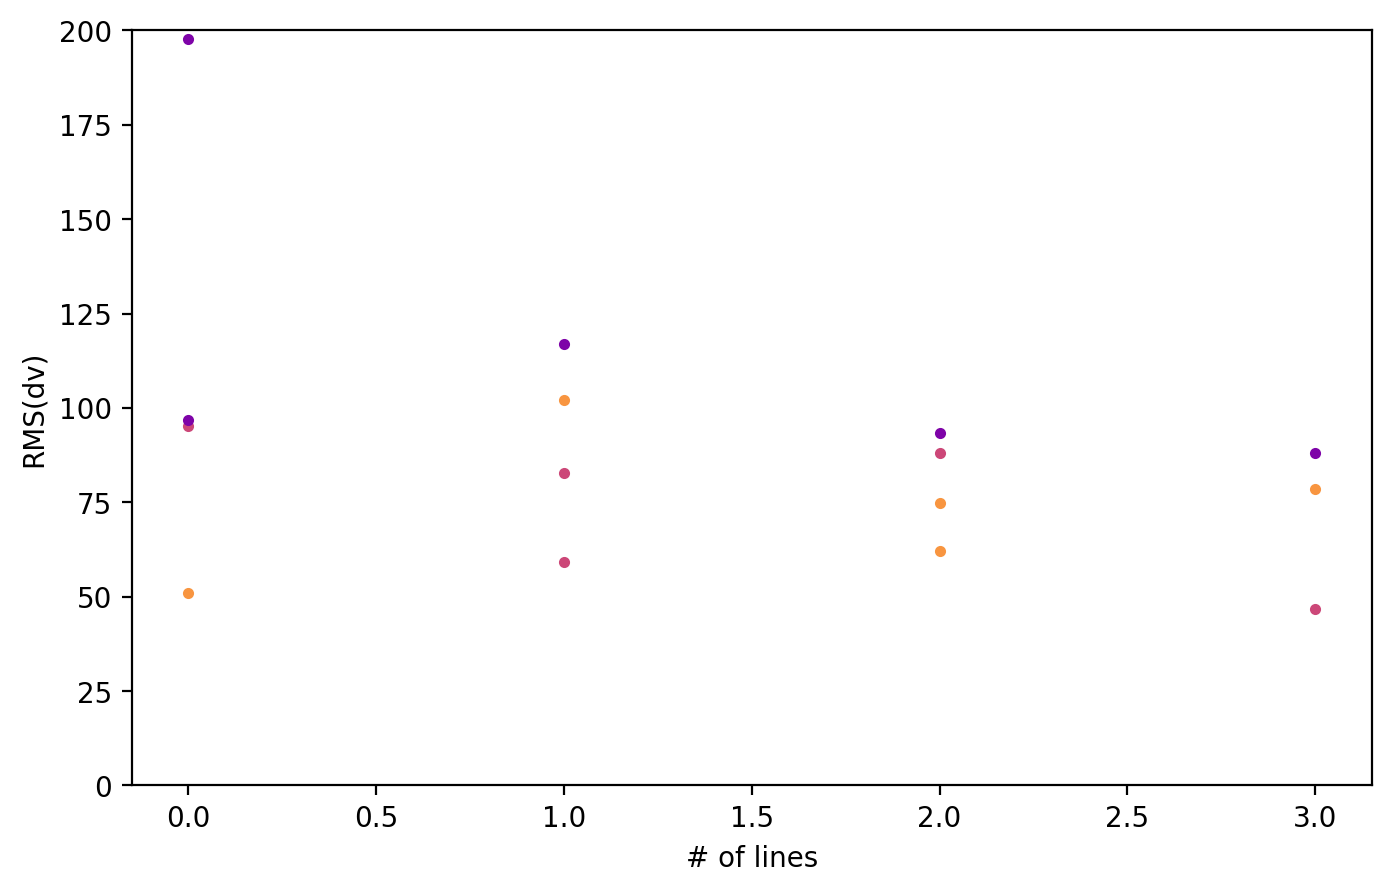

In [30]:
plt_ds = n_peaks
fig,ax = plt.subplots(1,figsize=(8,5),sharex=True,sharey=True,dpi=200,facecolor=(1,1,1))
# peak_vector = np.arange(2,n_peaks+2)
dv_vector = np.zeros(peaks_vector.shape)

worst_dv = RMS_DV(guess_vel.to(u.m/u.s).value,velocities.to(u.m/u.s).value)
# plt.hlines([worst_dv],np.min(peaks_vector),np.max(peaks_vector),'m',alpha=0.4)

for i,model in enumerate(model_list):
    colour = cm.plasma((model[1].p_val)/np.max(bspline_order))
    estimate_vel = jabble.dataset.velocities(model[0].p).to(u.m/u.s).value
    dv = RMS_DV(estimate_vel - estimate_vel.mean(), velocities.to(u.m/u.s).value - velocities.to(u.m/u.s).value.mean())
    ax.plot(i%bspline_order,dv,'.',color=colour)
plt.ylabel('RMS(dv)')
plt.xlabel('# of lines')
plt.ylim(0,200)
plt.savefig(os.path.join(out_dir,'52-rmsdv.png'))
plt.show()

In [31]:
for i,model in enumerate(model_list):
#     print('model #{}'.format(i))
#     print(model.results)
#     for result in model.results:
#         print(result['message'])
#         print(result['nit'])
    if model.results[1]['message'] == 'ABNORMAL_TERMINATION_IN_LNSRCH':
        print(i)

In [32]:
extra_vel.to(u.m/u.s).value.mean()

2.6048138385438846

In [33]:
velocities.to(u.m/u.s).value.mean()

2.6048138385445783

In [34]:
guess_vel.to(u.m/u.s).value.mean()

1.0913936421275138e-12

In [35]:
for i in range(len(datasets)):
    print(estimate_vel[i,:].mean())

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed